# Working with XDF data using MNE
The goal of this notebook is to import data saved using the LSL Lab Recorder, and run through some pre-processing steps using [MNE-Python](https://mne.tools/stable/index.html)!

In [32]:
import mne
import matplotlib.pyplot as plt
import pyxdf
import numpy as np

## Path to dataset

In [2]:
DATA_PATH = r'/Volumes/GoogleDrive/.shortcut-targets-by-id/1mvHxk9Ra9K7MmjQxaRYiZKwUw4Y8o841/AC23/DATA/car_racing_error/'
DATA_PATH+= 'sub-karan/ses-S001/eeg/sub-karan_ses-S001_task-Default_run-002_eeg.xdf'

In [3]:
# Read in the LSL streams from the XDF file
streams, header = pyxdf.load_xdf(DATA_PATH)

In [4]:
# Dict structure of a stream object
streams[0]

{'info': defaultdict(list,
             {'name': ['CGX Quick-32r Q32r-0524 Impedance'],
              'type': ['Impeadance'],
              'channel_count': ['37'],
              'nominal_srate': ['500'],
              'channel_format': ['float32'],
              'source_id': ['myuid323458'],
              'version': ['1.1000000000000001'],
              'created_at': ['450146.65643039998'],
              'uid': ['084f1894-da6e-4a59-850e-bcc625f2e0de'],
              'session_id': ['default'],
              'hostname': ['ecelab12'],
              'v4address': [None],
              'v4data_port': ['16573'],
              'v4service_port': ['16573'],
              'v6address': [None],
              'v6data_port': ['16573'],
              'v6service_port': ['16573'],
              'desc': [defaultdict(list,
                           {'channels': [defaultdict(list,
                                         {'channel': [defaultdict(list,
                                                     

In [5]:
# First time stamps for each stream
FIRST_TIME_STAMP = float(streams[0]['footer']['info']['first_timestamp'][0])
print(FIRST_TIME_STAMP)

for i in range(1, len(streams)):
    START_TIME = float(streams[i]['footer']['info']['first_timestamp'][0])
    print(START_TIME)
    
    # update the earliest time stamp seen if needed
    if START_TIME < FIRST_TIME_STAMP:
        FIRST_TIME_STAMP = float(START_TIME)

print(FIRST_TIME_STAMP, '<== earliest')   

450525.3666153
450525.3666127
455999.284710583
450525.3666127 <== earliest


# Collect stream info and data

In [20]:
# Identify EEG data and impedance streams

for s in streams:
    s_name = s['info']['name'][0]
    s_type = s['info']['type'][0]
    print(f'Stream Name: {s_name}\tType: {s_type}')
    
    # Get the EEG data stream for CGX
    if ('CGX' in s_name) and (s_type == 'EEG'):
        eeg_data = s['time_series']
        eeg_t = s['time_stamps'] - FIRST_TIME_STAMP # offset first time stamp to t=0
        eeg_ch_names = [ch['label'][0] for ch in s['info']['desc'][0]['channels'][0]['channel']]
        eeg_ch_units = [ch['unit'][0] for ch in s['info']['desc'][0]['channels'][0]['channel']]
        eeg_sfreq = s['info']['effective_srate']
        print(f'Channels: {eeg_ch_names}')
        print(f'Unit: {eeg_ch_units}')
        print(f'Eff. Sampling Rate: {eeg_sfreq} Hz')
        
    # Get the impedance data stream for CGX
    elif ('CGX' in s_name) and (s_type == 'Impeadance'): # typo in the stream name?
        z_data = s['time_series']
        z_t = s['time_stamps'] - FIRST_TIME_STAMP
        z_ch_names = [ch['label'][0] for ch in s['info']['desc'][0]['channels'][0]['channel']]
        z_ch_units = [ch['unit'][0] for ch in s['info']['desc'][0]['channels'][0]['channel']]
        z_sfreq = s['info']['effective_srate']
        print(f'Channels: {z_ch_names}')
        print(f'Unit: {z_ch_units}')
        print(f'Eff. Sampling Rate: {z_sfreq} Hz')
        
    # Keyboard events
    elif (s_type == 'Markers'):
        events = s['time_series']
        events_t = s['time_stamps'] - FIRST_TIME_STAMP

Stream Name: CGX Quick-32r Q32r-0524 Impedance	Type: Impeadance
Channels: ['AF7-Z', 'Fpz-Z', 'F7-Z', 'Fz-Z', 'T7-Z', 'FC6-Z', 'Fp1-Z', 'F4-Z', 'C4-Z', 'Oz-Z', 'CP6-Z', 'Cz-Z', 'PO8-Z', 'CP5-Z', 'O2-Z', 'O1-Z', 'P3-Z', 'P4-Z', 'P7-Z', 'P8-Z', 'Pz-Z', 'PO7-Z', 'T8-Z', 'C3-Z', 'Fp2-Z', 'F3-Z', 'F8-Z', 'FC5-Z', 'AF8-Z', 'A2-Z', 'ExG 1-Z', 'ExG 2-Z', 'ACC32-Z', 'ACC33-Z', 'ACC34-Z', 'Packet Counter-Z', 'TRIGGER-Z']
Unit: ['kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms', 'kohms']
Eff. Sampling Rate: 499.9378836336415 Hz
Stream Name: CGX Quick-32r Q32r-0524	Type: EEG
Channels: ['AF7', 'Fpz', 'F7', 'Fz', 'T7', 'FC6', 'Fp1', 'F4', 'C4', 'Oz', 'CP6', 'Cz', 'PO8', 'CP5', 'O2', 'O1', 'P3', 'P4', 'P7', 'P8', 'Pz', 'PO7', 'T8', '

In [8]:
print(eeg_data.shape)
eeg_data

(44545, 37)


array([[-5.1899750e+04, -3.7377242e+04, -4.1634326e+03, ...,
        -1.3950892e+05,  9.0000000e+00,  0.0000000e+00],
       [-5.1904039e+04, -3.7381773e+04, -4.1744912e+03, ...,
        -1.3950892e+05,  1.0000000e+01,  0.0000000e+00],
       [-5.1914141e+04, -3.7388668e+04, -4.1902798e+03, ...,
        -1.3950892e+05,  1.1000000e+01,  0.0000000e+00],
       ...,
       [-5.2162785e+04, -3.7685246e+04, -6.6808159e+03, ...,
        -1.5345983e+05,  7.0000000e+00,  0.0000000e+00],
       [-5.2157855e+04, -3.7681230e+04, -6.6759097e+03, ...,
        -1.5345983e+05,  8.0000000e+00,  0.0000000e+00],
       [-5.2152367e+04, -3.7678168e+04, -6.6728506e+03, ...,
        -1.4648438e+05,  9.0000000e+00,  0.0000000e+00]], dtype=float32)

In [26]:
print(sum(eeg_data[:, -1])) # no events in trigger channel
eeg_data[:, -1] # trigger channel

0.0


array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [9]:
events

[['1688426244.433863', 'enter'],
 ['1688426246.99614', 'left'],
 ['1688426248.46244', 'right'],
 ['1688426249.3262389', 'left'],
 ['1688426273.818625', 'right'],
 ['1688426274.1878269', 'left'],
 ['1688426277.2872891', 'right'],
 ['1688426277.5290701', 'left'],
 ['1688426287.1500008', 'right'],
 ['1688426288.071577', 'left'],
 ['1688426296.07071', 'right'],
 ['1688426298.764447', 'left'],
 ['1688426299.788563', 'left'],
 ['1688426300.393536', 'right'],
 ['1688426300.775326', 'right'],
 ['1688426301.3065999', 'left'],
 ['1688426301.7196958', 'left'],
 ['1688426303.294213', 'right'],
 ['1688426312.62571', 'left'],
 ['1688426313.9705632', 'right']]

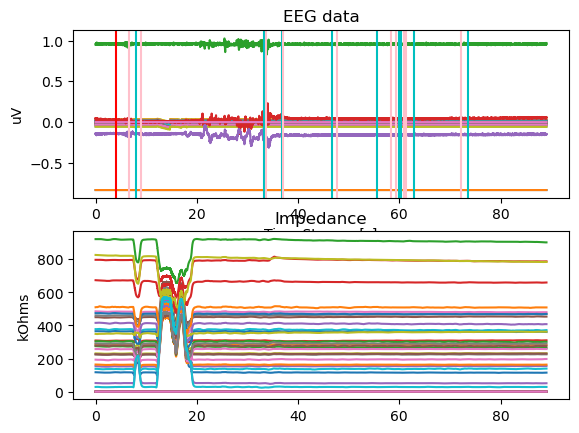

In [23]:
# Plot EEG data
fig, ax = plt.subplots(2, 1)

ax[0].plot(eeg_t, eeg_data)
ax[0].set_ylabel('uV')
ax[0].set_xlabel('Time Stamps [s]')
ax[0].set_title('EEG data')

# Plot event markers
for i in range(len(events)):
    event_t = events_t[i]
    event_v = events[i][0]
    event_type = events[i][1]
    
    if event_type == 'left':
        ax[0].axvline(x = event_t, c='pink')
    elif event_type == 'right':
        ax[0].axvline(x = event_t, c='c')
    elif event_type == 'enter':
        ax[0].axvline(x = event_t, c='r')
    
ax[1].plot(z_t, z_data)
ax[1].set_ylabel('kOhms')
ax[1].set_title('Impedance')

plt.show()

# Prepare to import data to mne

## Rescale EEG data to V
(only run this once!)

In [11]:
print(eeg_data[:, 0])

# Rescale units of eeg_data to V
if 'microvolts' in eeg_ch_units:
    eeg_data /= 1e6
    
print(eeg_data[:, 0])

[-51899.75  -51904.04  -51914.14  ... -52162.785 -52157.855 -52152.367]
[-0.05189975 -0.05190404 -0.05191414 ... -0.05216279 -0.05215786
 -0.05215237]


In [13]:
eeg_data.T.shape # mne expects (n_channels, n_times)

(37, 44545)

In [14]:
eeg_ch_names

['AF7',
 'Fpz',
 'F7',
 'Fz',
 'T7',
 'FC6',
 'Fp1',
 'F4',
 'C4',
 'Oz',
 'CP6',
 'Cz',
 'PO8',
 'CP5',
 'O2',
 'O1',
 'P3',
 'P4',
 'P7',
 'P8',
 'Pz',
 'PO7',
 'T8',
 'C3',
 'Fp2',
 'F3',
 'F8',
 'FC5',
 'AF8',
 'A2',
 'ExG 1',
 'ExG 2',
 'ACC32',
 'ACC33',
 'ACC34',
 'Packet Counter',
 'TRIGGER']

(Manually) Identify each channel's type for importing data to mne:

In [15]:
ch_types = []
ch_types.extend(['eeg']*29) # first 29 channels are EEG
ch_types.extend(['misc']*(1+2+3+1)) # A2 (assuming unused, ExG x2, ACC x3, Packet Counter)
ch_types.extend(['stim']) # Trigger channel (probably unused)

Make an info object for importing data to mne:

https://mne.tools/stable/generated/mne.create_info.html

In [16]:
info = mne.create_info(
    ch_names = eeg_ch_names,
    sfreq = eeg_sfreq,
    ch_types = ch_types,
)

Import the data as a raw array:

https://mne.tools/stable/generated/mne.io.RawArray.html

In [17]:
raw = mne.io.RawArray(
    data = eeg_data.T, # mne expects (n_channels, n_times)
    info = info,
)

raw

Creating RawArray with float64 data, n_channels=37, n_times=44545
    Range : 0 ... 44544 =      0.000 ...    89.099 secs
Ready.


<RawArray | 37 x 44545 (89.1 s), ~12.6 MB, data loaded>

## Apply the 10-20 channel montage

/var/folders/st/wjnxghxn7_b382gv3l4lxt0m0000gn/T/ipykernel_2832/3578104422.py:1: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.info.set_montage('standard_1020', match_case=False)


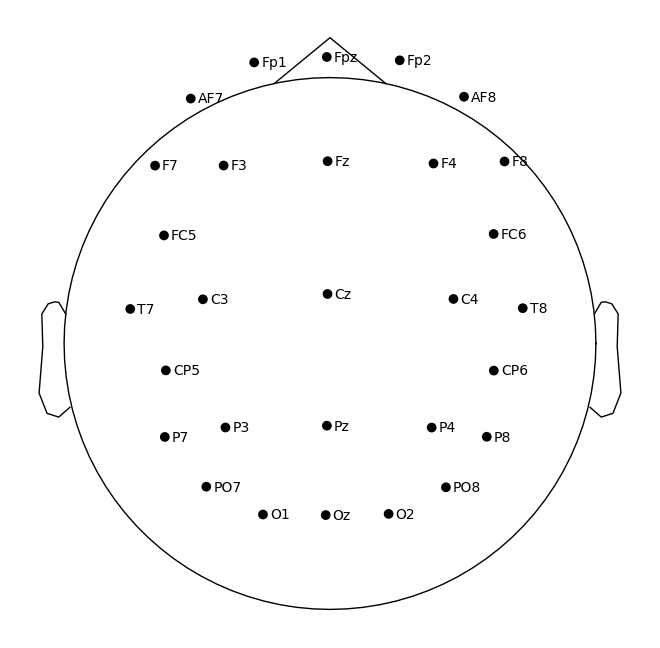

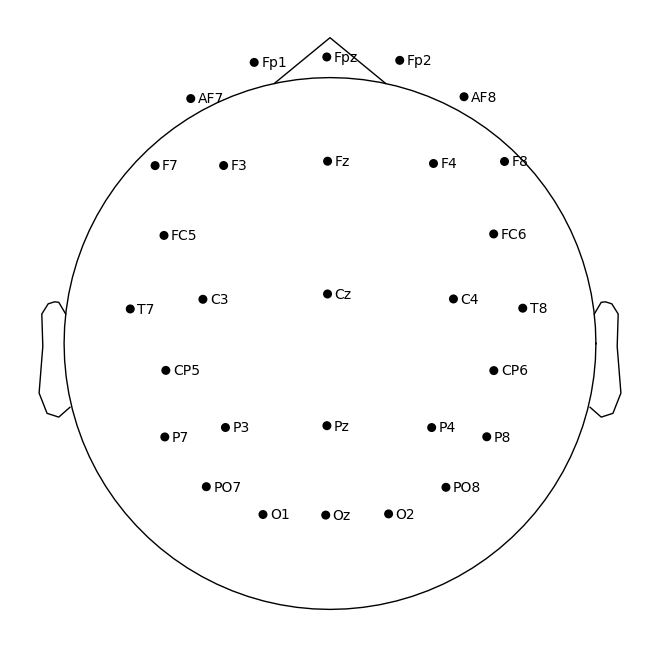

In [27]:
raw.info.set_montage('standard_1020', match_case=False)

# Plot the montage
mne.viz.plot_montage(raw.info.get_montage())

# Add annotations from marker stream

In [53]:
ev_id = [ev[1] for ev in events]
ev_id

['enter',
 'left',
 'right',
 'left',
 'right',
 'left',
 'right',
 'left',
 'right',
 'left',
 'right',
 'left',
 'left',
 'right',
 'right',
 'left',
 'left',
 'right',
 'left',
 'right']

In [55]:
lsl_annot = mne.Annotations(
    onset = events_t,
    duration = np.zeros_like(events_t),
    description = ev_id,
)

raw.set_annotations(lsl_annot)

<RawArray | 37 x 44545 (89.1 s), ~12.6 MB, data loaded>

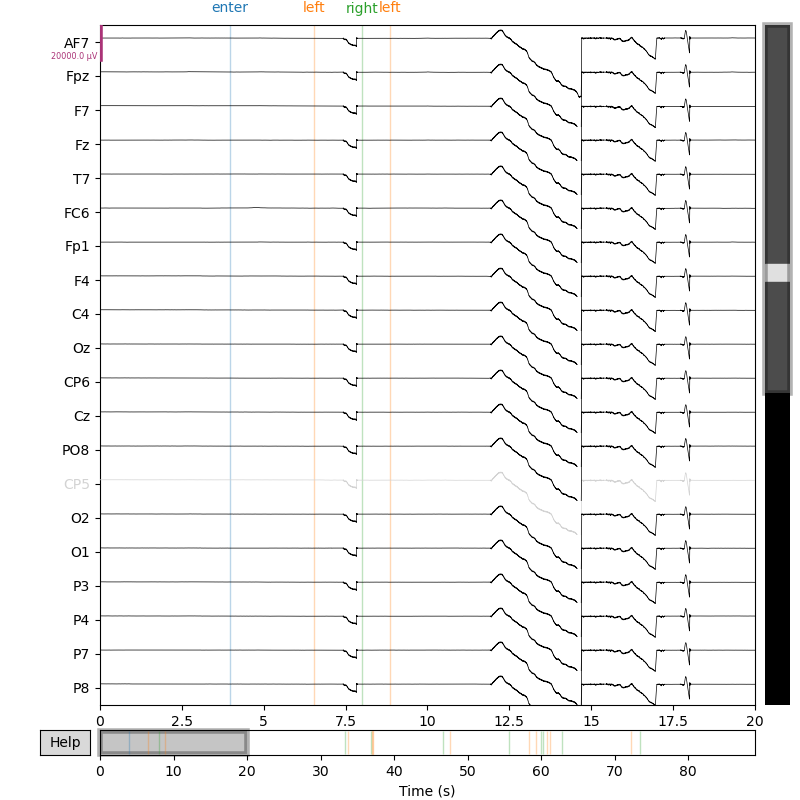

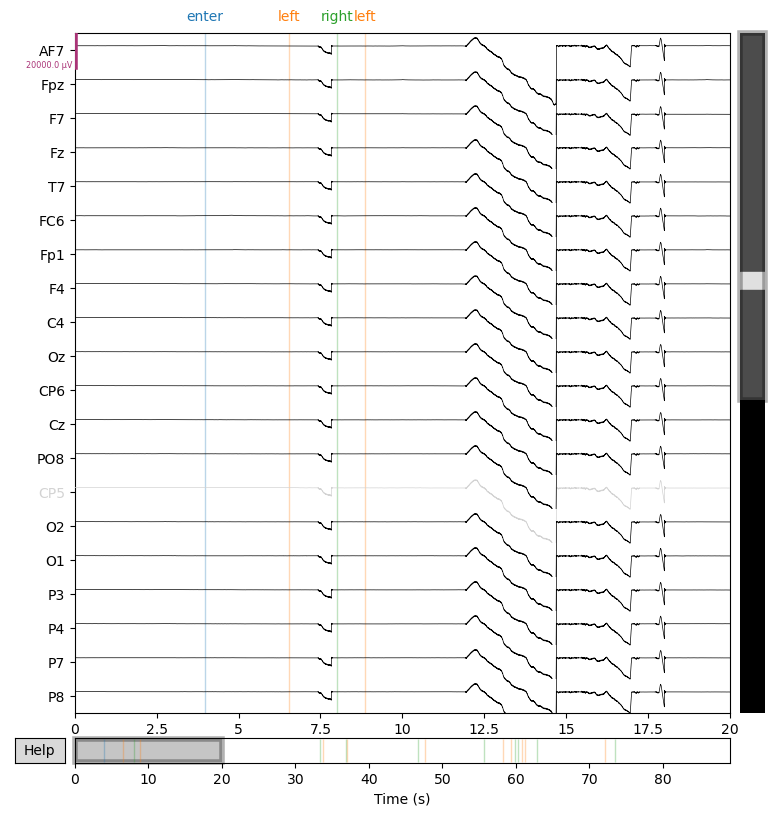

In [58]:
%matplotlib widget

# could go back to 
# %matplotlib inline 
# if the plot doubling becomes annoying

# using widget to make the plot interactive (for scrolling, bad channel selection, etc)

# scaling can help with visibility, especially if we have some bad channels / artifacts
scalings = {
    'eeg': 10e-3, 
    'eog': 500e-6,
    'misc': 100
} 

# In case you want to manually flag some channels as bad (could also click in the plot)
bad_chans = ['CP5']
raw.info['bads'] = bad_chans

PLOT_WINDOW_START_s = 0
PLOT_WINDOW_DUR_s = 20

raw.plot(
    scalings = scalings,
    #butterfly = True,
    start = PLOT_WINDOW_START_s,
    duration = PLOT_WINDOW_DUR_s,
)

Let's look at a power spectrum (before we do any filtering):

In [ ]:
raw.compute_psd(n_fft = 1024).plot(average = False)

Let's bandpass filter the data:

In [ ]:
raw_filt = raw.copy().filter( # make a copy of the array to avoid modifying in place
    l_freq = 0.1, # lower cut-off, in Hz
    h_freq = 50, # upper cut-off, in Hz
)

# And look at the PSD again
raw_filt.compute_psd(n_fft = 1024).plot(average = False)

n_fft = 1024

# picks = [''] # a list of channels that you want to focus on, if any
fig = raw_filt.compute_psd(
    # picks= picks,
    fmin = 0, # lower limit to plot
    fmax = 60, # upper limit to plot
    # tmin = 0, # if only using a subset of the data for PSD computation
    # tmax = 10,
    n_fft = n_fft,
).plot()

# Some reformatting if needed
# fig.get_axes()[0].set_ylim(YLIM_MIN, YLIM_MAX)
fig.get_axes()[0].set_title('Updated title!')
plt.show()

In [ ]:
## Update scalings if needed
# scalings['eeg'] = 200e-6 
scalings['eog'] = 500e-6
# scalings['misc'] = 100

raw_filt.info.bads = [] #'Oz', 'PO8', 'Fp2', 'F7', 'P3'] # ideally could label bad segments instead of dropping channels

# Drop bad channels from visual examination before running ICA
raw_filt_drop_bad = raw_filt.copy().drop_channels(raw_filt.info.bads)

raw_filt_drop_bad.plot(
    scalings = scalings,
    butterfly = True,
    start = PLOT_WINDOW_START_s,
    duration = PLOT_WINDOW_DUR_s,
)

## Re-reference to average
https://mne.tools/stable/generated/mne.set_eeg_reference.html

In [ ]:
raw_filt_drop_bad_rref, _ = mne.set_eeg_reference(
    raw_filt_drop_bad, 
    ref_channels='average',
)

raw_filt_drop_bad_rref.plot(
    scalings=scalings,
    butterfly=True,
    start = PLOT_WINDOW_START_s,
    duration = PLOT_WINDOW_DUR_s,
)

# Run ICA to remove artifacts
https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html#sphx-glr-auto-tutorials-preprocessing-40-artifact-correction-ica-py

In [ ]:
from mne.preprocessing import ICA

# Make an ICA object
ica = ICA(
    #n_components = 29, # number of prinicipal components passed to ICA
    random_state = 23, # seed for numpy RNG
    #method = 'infomax', # can use 'fastica' or 'picard' too
)

# Run ICA
ica.fit(raw_filt_drop_bad_rref)

## Plot ICA components over time

In [ ]:
%matplotlib widget
ica.plot_sources(
    raw_filt_drop_bad_rref,
    start = PLOT_WINDOW_START_s,
    stop = PLOT_WINDOW_START_s + PLOT_WINDOW_DUR_s,
)

## Topomaps for each ICA component

In [ ]:
ica.plot_properties(
    raw_filt_drop_bad_rref,
    picks = range(ica.n_components_) # select ICA components to plot topomaps for
)

## Remove suspect ICA components

In [ ]:
suspect_ica_components = [
    0, # eye blinks
    1, # pulse
]

ica.plot_overlay(
    raw_filt_drop_bad,
    exclude = suspect_ica_components,
    
    start = int(raw_filt_drop_bad.info['sfreq']) * PLOT_WINDOW_START_s, # this is index, not seconds
    stop = int(raw_filt_drop_bad.info['sfreq']) * (PLOT_WINDOW_START_s + PLOT_WINDOW_DUR_s),
)


## Project back to channel space

In [ ]:
raw_ica = ica.apply(
    raw_filt_drop_bad, 
    exclude=suspect_ica_components, # ICA components to drop
)

In [ ]:
raw_ica.plot(
    scalings = scalings,
    butterfly = True,
    duration = PLOT_WINDOW_DUR_s,
    start = PLOT_WINDOW_START_s,
)

# Lets find events from annotations

In [ ]:
events = mne.events_from_annotations(raw_ica)

In [ ]:
events

In [ ]:
event_id

In [ ]:
eps = mne.Epochs(
    #raw_filt,
    raw_ica,
    events = events, 
    event_id = event_id, 
    tmin=-0.5,
    tmax=1.5,
    baseline=None,
)

%matplotlib inline

for ev_id in event_id:
    eps[ev_id].plot_image(
        #picks = [],
        combine='mean'
    )

In [ ]:
for ev_id in event_id:
    eps[ev_id].average(
        # picks = []
    ).plot_joint()